In [1]:
from dotenv import load_dotenv

from pathlib import Path
import os 
import sys
import numpy as np
import json

load_dotenv()
GEMINI_KEY = os.getenv('GEMINI_KEY')

root = Path().resolve().parent

root_str = str(root)
if root_str not in sys.path:
    sys.path.insert(0, root_str)

if Path.cwd() != root:
    os.chdir(root)

# Results

In [2]:
import pandas as pd
import json
from pprint import pprint

results = json.load(open("results/bench_results.json"))

reshuffle = {}
for metric in ["is_valid", "correctness", "compliance"]:
    reshuffle[metric] = {
        model: {
            task: results[model][task][metric] if metric in results[model][task] else None
            for task in results[model]
        }
        for model in results
    }

def format_table(metric="is_valid", columns=None):
    df = pd.DataFrame(reshuffle[metric])
    if not columns:
        columns = df.columns
    df = df.loc[:, columns]
    return df.style.background_gradient(cmap="RdYlGn", vmin=0.2, vmax=1).format("{:.2f}")


for metric in ["is_valid", "compliance", "correctness"]:
    print("-"*100)
    print(metric)
    display(format_table(metric))
    print("\n")

----------------------------------------------------------------------------------------------------
is_valid


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.90,1.00,1.00,1.00,0.90,0.90,0.90,0.00,0.25,0.81,0.00,0.95,0.90,0.90,0.90,0.05,0.70,1.00,nan,0.81,0.02
2-wiki_bio,1.00,1.00,1.00,0.92,0.90,0.73,0.62,0.01,0.29,0.50,0.00,0.98,0.69,0.83,0.84,0.05,1.00,1.00,nan,0.89,0.96
3-few_nerd,0.93,1.00,1.00,0.96,0.90,0.90,0.90,0.00,0.01,0.00,0.00,0.89,0.90,0.90,0.90,0.06,1.00,0.07,nan,0.77,0.78
4-TOPv1,0.93,1.00,1.00,0.99,0.90,0.86,0.89,0.00,0.99,0.01,0.00,1.00,0.90,0.90,0.90,0.00,0.98,0.57,nan,0.00,1.00
5-api_bank,0.99,1.00,0.99,1.00,0.91,1.00,0.96,0.00,1.00,0.19,0.26,0.97,1.00,0.86,0.82,0.04,1.00,1.00,nan,0.42,0.94
6-reasoning/GSM8K,0.89,1.00,1.00,0.90,0.90,0.84,0.80,0.00,0.00,0.69,0.16,0.92,0.92,0.79,0.73,0.02,0.95,0.94,nan,0.74,0.98
6-reasoning/last_letter,0.90,1.00,1.00,0.90,0.90,0.90,0.66,0.00,0.00,0.98,0.00,1.00,0.90,0.90,0.00,0.00,1.00,1.00,nan,0.00,1.00




----------------------------------------------------------------------------------------------------
compliance


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,1.00,1.00,0.93,0.91,1.00,0.98,0.91,0.00,0.00,0.88,0.84,0.76,0.99,0.94,0.86,0.61,0.03,0.89,nan,0.89,0.01
2-wiki_bio,0.97,0.97,0.85,0.84,0.96,0.97,0.85,0.01,0.36,0.82,0.68,0.99,0.97,0.96,0.85,0.42,1.00,1.00,nan,0.96,1.00
3-few_nerd,1.00,1.00,1.00,1.00,1.00,0.99,1.00,0.00,0.00,0.75,0.63,0.00,1.00,1.00,1.00,0.92,1.00,0.92,nan,1.00,0.00
4-TOPv1,0.95,0.99,0.99,0.94,1.00,0.77,0.83,0.00,0.00,0.62,0.01,0.00,0.83,0.77,0.79,0.36,0.00,0.33,nan,0.33,0.00
5-api_bank,0.99,1.00,0.99,0.99,0.99,1.00,0.99,0.00,0.00,0.21,0.07,0.00,1.00,0.98,0.99,0.09,0.66,0.75,nan,0.87,0.00
6-reasoning/GSM8K,1.00,1.00,0.81,0.68,1.00,1.00,0.89,0.03,0.51,0.86,0.38,0.95,1.00,0.97,0.94,0.85,0.97,0.96,nan,0.91,0.99
6-reasoning/last_letter,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.01,0.50,1.00,0.49,1.00,1.00,1.00,1.00,0.49,1.00,1.00,nan,0.47,1.00




----------------------------------------------------------------------------------------------------
correctness


,gemini-2.5-flash,gemini-2.5-flash_jsonmode,gemini-2.5-flash_jsonmode_low,gemini-2.5-flash_low,gemini-2.5-pro,gemma-3-12b-it,gemma-3-12b-it_low,gemma-3-12b-it_vllm,gemma-3-12b-it_vllm_outlines,gemma-3-1b-it,gemma-3-1b-it_vllm,gemma-3-1b-it_vllm_outlines,gemma-3-27b-it,gemma-3-4b-it,gemma-3-4b-it_low,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_guidance,gemma-3-4b-it_transformers_outlines,gemma-3-4b-it_transformers_reasoning_free,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines
1-rotowire,0.54,0.56,0.50,0.50,0.56,0.54,0.54,0.00,0.00,0.40,0.23,0.20,0.50,0.49,0.45,0.30,0.01,0.47,nan,0.45,0.00
2-wiki_bio,0.33,0.33,0.33,0.33,0.34,0.32,0.33,0.00,0.00,0.24,0.21,0.27,0.33,0.35,0.33,0.16,0.35,0.35,nan,0.35,0.28
3-few_nerd,0.60,0.58,0.59,0.59,0.55,0.40,0.40,0.00,0.00,0.23,0.16,0.00,0.39,0.43,0.40,0.40,0.42,0.35,nan,0.43,0.01
4-TOPv1,0.64,0.65,0.63,0.63,0.66,0.50,0.56,0.00,0.00,0.25,0.00,0.00,0.60,0.51,0.50,0.22,0.12,0.21,nan,0.21,0.00
5-api_bank,0.92,0.91,0.90,0.91,0.91,0.81,0.78,0.00,0.00,0.32,0.12,0.00,0.82,0.80,0.81,0.08,0.63,0.64,nan,0.69,0.00
6-reasoning/GSM8K,0.93,0.92,0.59,0.42,0.94,0.89,0.79,0.00,0.00,0.32,0.04,0.09,0.91,0.84,0.76,0.67,0.80,0.78,0.72,0.74,0.41
6-reasoning/last_letter,0.98,0.97,0.97,0.97,0.98,0.81,0.75,0.00,0.00,0.00,0.00,0.00,0.84,0.17,0.47,0.01,0.47,0.38,0.41,0.02,0.12


### Baseline

In [17]:
def pretty_table(
    df,
    title=None,
    cmap="RdYlGn",
    vmin=0.2,
    vmax=1.0,
    precision=2
):
    return (
        df.style
          # format numbers
          .format(f"{{:.{precision}f}}")
          # apply the heatmap gradient
          .background_gradient(cmap=cmap, vmin=vmin, vmax=vmax)
          # simple plain-text caption
          .set_caption(title or "")
          # table-wide CSS
          .set_table_styles([
              # header cells
              {
                  "selector": "th",
                  "props": [
                      ("background-color", "white"),
                      ("color", "black"),
                      ("font-weight", "bold"),
                      ("padding", "6px"),
                      ("border", "1px solid #ddd")
                  ]
              },
              # data cells
              {
                  "selector": "td",
                  "props": [
                      ("padding", "4px"),
                      ("border", "1px solid #ddd"),
                      ("text-align", "center")
                  ]
              },
              # caption styling
              {
                  "selector": "caption",
                  "props": [
                      ("caption-side", "top"),
                      ("font-size", "14pt"),
                      ("font-weight", "bold"),
                      ("text-align", "center"),
                      ("color", "black")
                  ]
              },
          ])
    )

In [18]:
tasks = list( next(iter(reshuffle.values())).keys() )  
columns = ["gemini-2.5-pro", "gemini-2.5-flash",
                    "gemma-3-27b-it", "gemma-3-12b-it",  "gemma-3-4b-it","gemma-3-1b-it"]
models = columns                                   

for metric, name in zip(["is_valid","compliance","correctness"], ["JSON Validity", "Format Compliance", "Content Correctness"]):
    df = pd.DataFrame(reshuffle[metric])[columns]
    display(
        pretty_table(
          df, 
          title=name  # e.g. "Is Valid"
        )
    )

,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,0.90,0.90,0.90,0.90,0.90,0.81
2-wiki_bio,0.90,1.00,0.69,0.73,0.83,0.50
3-few_nerd,0.90,0.93,0.90,0.90,0.90,0.00
4-TOPv1,0.90,0.93,0.90,0.86,0.90,0.01
5-api_bank,0.91,0.99,1.00,1.00,0.86,0.19
6-reasoning/GSM8K,0.90,0.89,0.92,0.84,0.79,0.69
6-reasoning/last_letter,0.90,0.90,0.90,0.90,0.90,0.98


,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,1.00,1.00,0.99,0.98,0.94,0.88
2-wiki_bio,0.96,0.97,0.97,0.97,0.97,0.85
3-few_nerd,1.00,1.00,1.00,0.99,1.00,0.75
4-TOPv1,1.00,0.95,0.83,0.77,0.77,0.62
5-api_bank,0.99,0.99,1.00,1.00,0.98,0.21
6-reasoning/GSM8K,1.00,1.00,1.00,1.00,0.97,0.86
6-reasoning/last_letter,1.00,1.00,1.00,1.00,1.00,1.00


,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
1-rotowire,0.56,0.54,0.50,0.54,0.49,0.40
2-wiki_bio,0.34,0.33,0.33,0.32,0.35,0.24
3-few_nerd,0.55,0.60,0.39,0.40,0.43,0.23
4-TOPv1,0.66,0.64,0.60,0.50,0.51,0.25
5-api_bank,0.91,0.92,0.82,0.81,0.80,0.32
6-reasoning/GSM8K,0.94,0.93,0.91,0.89,0.84,0.32
6-reasoning/last_letter,0.98,0.98,0.84,0.81,0.17,0.00


In [20]:
def agg_results(results, models=None):
    agg = {}
    for model in models if models else results:
        agg[model] = {}
        for metric in ["is_valid", "compliance", "correctness"]:
            li = [results[model][task][metric] for task in results[model]]
            agg[model][metric] = np.mean(li)
    return agg

t = pd.DataFrame(agg_results(results, models=columns))
t

,gemini-2.5-pro,gemini-2.5-flash,gemma-3-27b-it,gemma-3-12b-it,gemma-3-4b-it,gemma-3-1b-it
is_valid,0.901571,0.934714,0.885429,0.875286,0.868286,0.455286
compliance,0.994000,0.987286,0.969429,0.958286,0.948571,0.737714
correctness,0.706429,0.705000,0.628429,0.608714,0.513143,0.252429


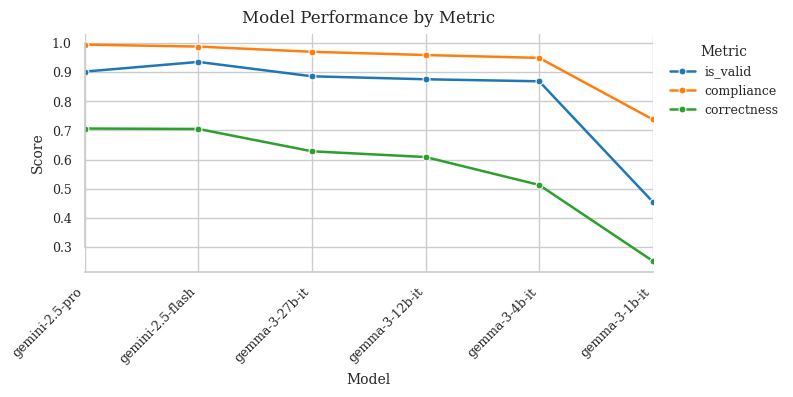

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Tighter context + smaller fonts
sns.set_theme(
    style="whitegrid",
    context="notebook",   # a bit bigger than "paper", but more compact overall
    font="serif",
    font_scale=1.0        # dial back the text size
)

df = t.T

# 2) Much shorter height, same width
fig, ax = plt.subplots(figsize=(8, 3.5))   # width 8", height 3.5"

palette = sns.color_palette("tab10", n_colors=len(df.columns))

# 3) Draw with no dashes, smaller markers
sns.lineplot(
    data=df,
    ax=ax,
    palette=palette,
    linewidth=1.8,
    marker="o",
    markersize=5,
    dashes=False,
)

# 4) Labels & ticks with minimal padding
ax.set_xlabel("Model", labelpad=5, fontsize=10)
ax.set_ylabel("Score", labelpad=5, fontsize=10)
ax.set_title("Model Performance by Metric", pad=8, fontsize=12)

ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, rotation=45, ha="right", fontsize=9)
ax.tick_params(axis="y", labelsize=9)

# 5) Manual legend outside
ax.legend(
    title="Metric",
    loc="upper left",
    bbox_to_anchor=(1.01, 1.0),
    frameon=False,
    title_fontsize=10,
    fontsize=9
)

# 6) Kill extra margins & spine‐trim
ax.margins(x=0)                # hugs the x‐axis labels more tightly
sns.despine(trim=True)
plt.subplots_adjust(
    left=0.07,                  # more room on the left so y‐label isn't squished
    right=0.78,                 # carve out space for the legend
    top=0.88,
    bottom=0.2                  # lifts the x‐labels up so they don't overlap
)

plt.show()


In [3]:
import pandas as pd
import json
from pprint import pprint

results = json.load(open("results/bench_results.json"))

reshuffle = {}
for metric in ["is_valid", "correctness", "compliance"]:
    reshuffle[metric] = {
        model: {
            task: results[model][task][metric]
            for task in results[model]
        }
        for model in results
    }

def format_table(metric="is_valid"):
    df = pd.DataFrame(reshuffle[metric])
    df = df.loc[:, ["gemma-3-4b-it", "gemma-3-4b-it_vllm",
                    "gemma-3-4b-it_vllm_outlines", "gemma-3-4b-it_transformers", "gemma-3-4b-it_transformers_outlines"]]
    return df.style.background_gradient(cmap="RdYlGn", vmin=0.2, vmax=1).format("{:.2f}")


for metric in ["is_valid", "compliance", "correctness"]:
    print("-"*100)
    print(metric)
    display(format_table(metric))
    print("\n")

----------------------------------------------------------------------------------------------------
is_valid


,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines
1-rotowire,0.90,0.81,0.02,0.05,1.00
2-wiki_bio,0.83,0.89,0.96,0.05,1.00
3-few_nerd,0.90,0.77,0.78,0.06,0.07
4-TOPv1,0.90,0.00,1.00,0.00,0.57
5-api_bank,0.86,0.42,0.94,0.04,1.00
6-reasoning/GSM8K,0.79,0.74,0.98,0.02,1.00
6-reasoning/last_letter,0.90,0.00,1.00,0.00,1.00




----------------------------------------------------------------------------------------------------
compliance


,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines
1-rotowire,0.94,0.89,0.01,0.61,0.92
2-wiki_bio,0.96,0.96,0.98,0.42,1.00
3-few_nerd,1.00,1.00,0.00,0.92,0.92
4-TOPv1,0.77,0.33,0.00,0.36,0.33
5-api_bank,0.98,0.87,0.00,0.09,0.75
6-reasoning/GSM8K,0.97,0.91,0.99,0.85,1.00
6-reasoning/last_letter,1.00,0.47,1.00,0.49,1.00




----------------------------------------------------------------------------------------------------
correctness


,gemma-3-4b-it,gemma-3-4b-it_vllm,gemma-3-4b-it_vllm_outlines,gemma-3-4b-it_transformers,gemma-3-4b-it_transformers_outlines
1-rotowire,0.49,0.45,0.00,0.30,0.47
2-wiki_bio,0.34,0.35,0.28,0.16,0.35
3-few_nerd,0.43,0.43,0.01,0.40,0.35
4-TOPv1,0.51,0.21,0.00,0.22,0.21
5-api_bank,0.80,0.69,0.00,0.08,0.64
6-reasoning/GSM8K,0.84,0.74,0.41,0.67,1.00
6-reasoning/last_letter,0.17,0.02,0.12,0.01,1.00
